In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

from xgboost import XGBClassifier
import time
from sklearn.preprocessing import MinMaxScaler

In [19]:
train_dir = "/kaggle/input/coffee-bean-tanvir/train"
test_dir  = "/kaggle/input/coffee-bean-tanvir/test"

# Training Data Generator (with validation split)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(128,128), batch_size=32,
    class_mode='categorical', shuffle=True, subset='training'
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(128,128), batch_size=32,
    class_mode='categorical', shuffle=False, subset='validation'
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(128,128), batch_size=32,
    class_mode='categorical', shuffle=False
)

print("Train classes mapping:", train_gen.class_indices)
print("Validation classes mapping:", val_gen.class_indices)
print("Test classes mapping:", test_gen.class_indices)


Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Train classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Validation classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Test classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [20]:
def self_attention_block(x, num_heads=4, key_dim=32, ff_dim=128):
    h, w, c = x.shape[1], x.shape[2], x.shape[3]
    reshaped = layers.Reshape((-1, c))(x)

    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(reshaped, reshaped)
    attn_output = layers.Add()([reshaped, attn_output])
    attn_output = layers.LayerNormalization()(attn_output)

    ffn = layers.Dense(ff_dim, activation='relu')(attn_output)
    ffn = layers.Dense(c)(ffn)
    ffn_output = layers.Add()([attn_output, ffn])
    ffn_output = layers.LayerNormalization()(ffn_output)

    return layers.Reshape((h, w, c))(ffn_output)


In [21]:
def build_sa_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = self_attention_block(x, num_heads=4, key_dim=32, ff_dim=128)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = self_attention_block(x, num_heads=4, key_dim=32, ff_dim=256)

    gap = layers.GlobalAveragePooling2D()(x)

    dense = layers.Dense(256, activation='relu')(gap)
    dense = layers.Dropout(0.5)(dense)
    outputs = layers.Dense(num_classes, activation='softmax')(dense)

    return models.Model(inputs, outputs)


In [22]:
num_classes = train_gen.num_classes
sa_model = build_sa_cnn(input_shape=(128,128,3), num_classes=num_classes)

sa_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = sa_model.fit(
    train_gen, validation_data=val_gen, epochs=20, verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 331ms/step - accuracy: 0.2754 - loss: 1.6491 - val_accuracy: 0.4917 - val_loss: 1.2817
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.4572 - loss: 1.1167 - val_accuracy: 0.6125 - val_loss: 0.8710
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.5944 - loss: 0.8209 - val_accuracy: 0.7917 - val_loss: 0.6020
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.7621 - loss: 0.5601 - val_accuracy: 0.9083 - val_loss: 0.2575
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.8816 - loss: 0.3227 - val_accuracy: 0.8333 - val_loss: 0.4030
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9168 - loss: 0.2418 - val_accuracy: 0.8875 - val_loss: 0.3078
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - accuracy: 0.9393 - loss: 0.1846 - val_accuracy: 0.9750 - val_loss: 0.0723
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - accuracy: 0.9524 - loss: 0.1561 - val_accuracy: 0

In [23]:
# Take output before Dense head (GAP layer)
feature_extractor = models.Model(
    inputs=sa_model.input,
    outputs=sa_model.layers[-4].output
)

def extract_features(model, generator):
    features, labels = [], []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = model.predict(x_batch, verbose=0)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))
    return np.vstack(features), np.hstack(labels)

X_train, y_train = extract_features(feature_extractor, train_gen)
X_val, y_val     = extract_features(feature_extractor, val_gen)
X_test, y_test   = extract_features(feature_extractor, test_gen)


In [24]:
# Apply MinMaxScaler to the extracted features

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [25]:
xgb_clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

xgb_clf.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
# ---- Training ----
start_time = time.time()
xgb_clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Training Time: {train_time:.4f} seconds")

# ---- Validation ----
start_time = time.time()
y_val_pred = xgb_clf.predict(X_val_scaled)
val_time = time.time() - start_time
print(f"Validation Prediction Time: {val_time:.4f} seconds")
print("Validation Accuracy (XGBoost):", accuracy_score(y_val, y_val_pred))

# ---- Testing ----
start_time = time.time()
y_test_pred = xgb_clf.predict(X_test_scaled)
test_time = time.time() - start_time
print(f"Test Prediction Time: {test_time:.4f} seconds")
print("Test Accuracy (XGBoost):", accuracy_score(y_test, y_test_pred))

# ---- Classification Report ----
print(classification_report(y_test, y_test_pred, target_names=list(train_gen.class_indices.keys())))

Training Time: 0.2887 seconds
Validation Prediction Time: 0.0014 seconds
Validation Accuracy (XGBoost): 0.9875
Test Prediction Time: 0.0010 seconds
Test Accuracy (XGBoost): 0.9775
              precision    recall  f1-score   support

        Dark       0.99      0.95      0.97       100
       Green       1.00      0.98      0.99       100
       Light       0.99      0.99      0.99       100
      Medium       0.93      0.99      0.96       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



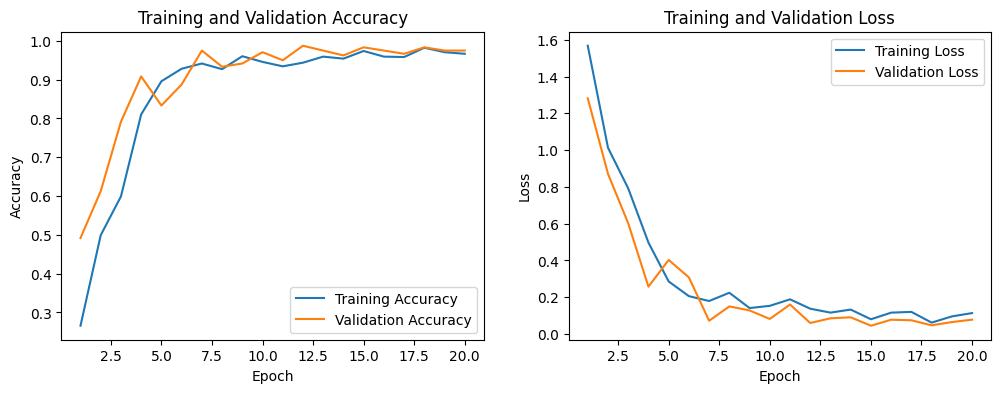

In [27]:
# Training Curves (Accuracy & Loss)
# ======================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

Accuracy: 0.9775
Precision (macro): 0.9783863993710692
Recall (macro): 0.9775
F1-score (macro): 0.97761294838618
Confusion Matrix:
 [[95  0  0  5]
 [ 0 98  1  1]
 [ 0  0 99  1]
 [ 1  0  0 99]]

Classification Report:
               precision    recall  f1-score   support

        Dark       0.99      0.95      0.97       100
       Green       1.00      0.98      0.99       100
       Light       0.99      0.99      0.99       100
      Medium       0.93      0.99      0.96       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



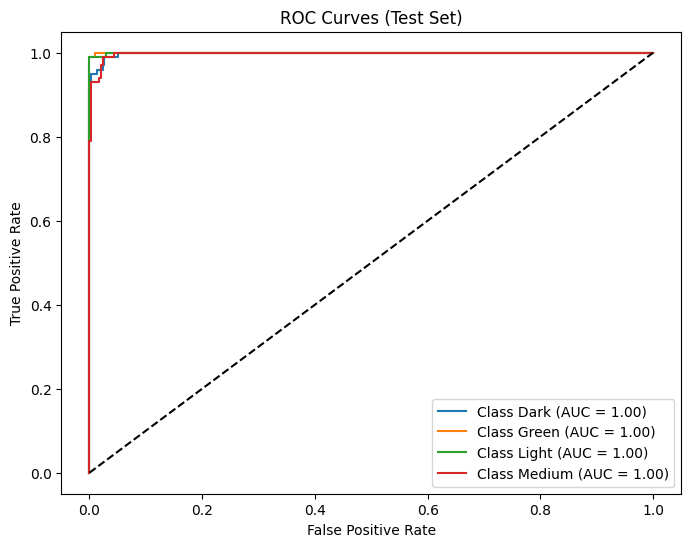

Overall Test AUC: 0.9989916666666667


In [28]:
# Predictions
y_test_pred = xgb_clf.predict(X_test_scaled)
y_test_proba = xgb_clf.predict_proba(X_test_scaled)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision (macro):", precision_score(y_test, y_test_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_test_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=list(test_gen.class_indices.keys())))

# ROC Curves
classes_present = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes_present)

if y_test_bin.shape[1] > 1:
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {list(test_gen.class_indices.keys())[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend(); plt.show()

    print("Overall Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")


Last Conv Layer Detected: conv2d_5
True label: Dark
Predicted label: Dark


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_29']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


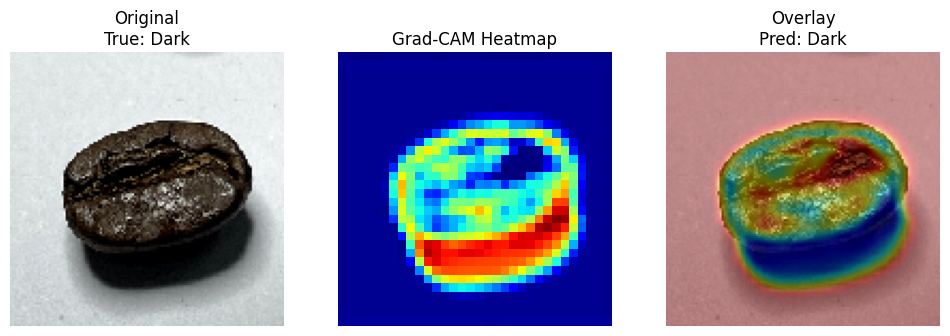

In [29]:
import cv2
import matplotlib.cm as cm

# === Grad-CAM Heatmap Generator ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# === Overlay Heatmap ===
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    return heatmap, overlayed

# === Auto-detect last Conv2D layer ===
last_conv_layer_name = [layer.name for layer in sa_model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
print("Last Conv Layer Detected:", last_conv_layer_name)

# === Pick 1 test image ===
sample_img, sample_label = test_gen[0][0][0], test_gen[0][1][0]
img_array = np.expand_dims(sample_img, axis=0)

# Prediction
preds = sa_model.predict(img_array, verbose=0)
pred_class = np.argmax(preds[0])
true_class = np.argmax(sample_label)
class_labels = list(train_gen.class_indices.keys())

print("True label:", class_labels[true_class])
print("Predicted label:", class_labels[pred_class])

# Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, sa_model, last_conv_layer_name)

# Original and overlay
original_img = np.uint8(255 * sample_img)
heatmap_img, overlay_img = overlay_heatmap(original_img, heatmap)

# Plot results
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(original_img)
plt.title(f"Original\nTrue: {class_labels[true_class]}")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay_img)
plt.title(f"Overlay\nPred: {class_labels[pred_class]}")
plt.axis("off")

plt.show()